In [26]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d 
from scipy.optimize import fminbound
from scipy.optimize import fixed_point

In [27]:
# Defining Maximize function and its maximizer on interval [a,b]

def maximum(V, a, b):
    return float(V(fminbound(lambda x: -V(x), a, b)))

def maximizer(V, a, b):
    return float(fminbound(lambda x: -V(x), a, b))

In [54]:
### Setting Economic Enviroment

# Defining Basic Function

def u(c, σ = 2):
    return ( c ** (1-σ) ) / (1-σ)

# Assigning Parameters

ρ = 0.06; β = 1 / (1 + ρ) ; r = 0.04

# Saving's Grid
A_l = 0
A_h = 5
grid_min = A_l ; grid_max = A_h ; grid_size = 100
a_grid = np.linspace(grid_min, grid_max, grid_size)

σ_y = 0.3 # Income Volatility
y_l = 1 - σ_y ; y_h = 1 + σ_y  # The two possible income process
δ = 0.95 # Persistence of income process

π = np.array([[(1 + δ) / 2, (1 - δ) / 2],[(1 - δ) / 2, (1 + δ) / 2]])

In [29]:
### Value Function Iteration

# Initial Guess
V_l = interp1d(a_grid, a_grid)
V_h = interp1d(a_grid, a_grid)

# Iteration Process
max_iter = 1000
tol = 1e-06
count = 0

while count < max_iter:
    
    vals = []
    for a in a_grid:
        y = y_l
        a_max = min(A_h, y + (1 + r) * a)
        h = lambda a_prime: u(max(y + (1 + r) * a - a_prime, 0)) + β * (π[0,0] * V_l(a_prime) + π[0,1] * V_h(a_prime))
        vals.append(float(maximum(h, A_l, a_max)))
                              
    V_l1 = interp1d(a_grid, vals)
                              
    vals = []
    for a in a_grid:
        y = y_h
        a_max = min(A_h, y + (1 + r) * a)
        h = lambda a_prime: u(max(y + (1 + r) * a - a_prime, 0)) + β * (π[1,0] * V_l(a_prime) + π[1,1] * V_h(a_prime))
        vals.append(float(maximum(h, A_l, a_max)))
                              
    V_h1 = interp1d(a_grid, vals)
                              
    err1 = np.max(np.abs(V_l1(a_grid) - V_l(a_grid)))
    err2 = np.max(np.abs(V_h1(a_grid) - V_h(a_grid)))
    err = np.max(np.array([err1, err2]))
                              
                              
    if err < tol:
        print('The Final Iteration Number is ', count)
        print('with error', err)
        break
    
    V_l = V_l1
    V_h = V_h1
    
    count += 1
                              
    if int(count) % 50 == 0 :
        print('The Iteration Number is', count)

The Iteration Number is 50
The Iteration Number is 100
The Iteration Number is 150
The Iteration Number is 200
The Final Iteration Number is  240
with error 9.537431839845567e-07


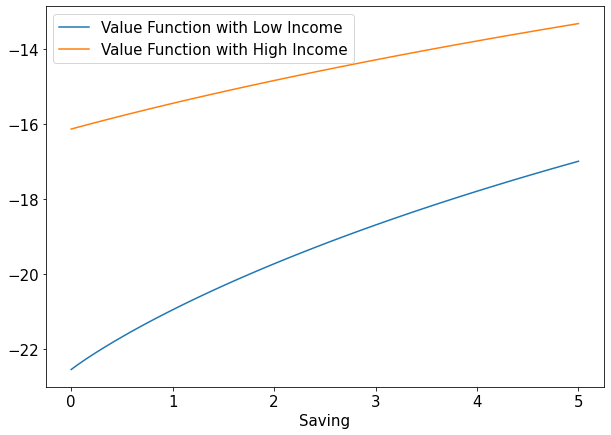

In [99]:
plt.figure(figsize=(10, 7))
plt.plot(a_grid, V_l(a_grid), label = "Value Function with Low Income")
plt.plot(a_grid, V_h(a_grid), label = "Value Function with High Income")
plt.legend(fontsize = 15)
plt.xlabel('Saving', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

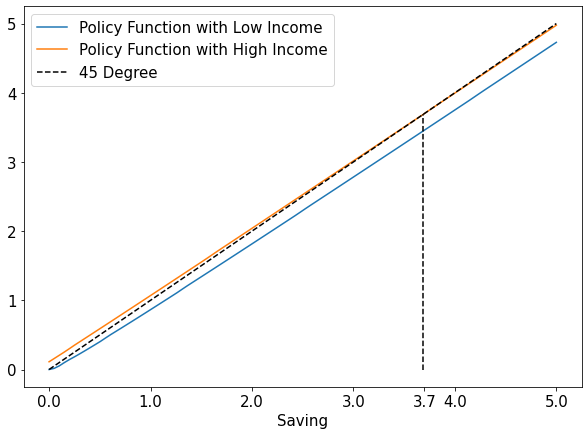

In [100]:
## Corresponding Policy Function

# Defining Policy Function

def policy_l(w,z):
    vals = []
    for a in a_grid:
        y = y_l
        a_max = min(A_h, y + (1 + r) * a)
        h = lambda a_prime: u(max(y + (1 + r) * a - a_prime, 0)) + β * ( π[0,0] * w(a_prime) + π[0,1] * z(a_prime))
        vals.append(float(maximizer(h, A_l, a_max)))
        
    return interp1d(a_grid, vals, kind = 'linear')        

def policy_h(w,z):
    vals = []
    for a in a_grid:
        y = y_h
        a_max = min(A_h, y + (1 + r) * a)
        h = lambda a_prime: u(max(y + (1 + r) * a - a_prime, 0)) + β * ( π[1,0] * w(a_prime) + π[0,0] * z(a_prime))
        vals.append(float(maximizer(h, A_l, a_max)))
        
    return interp1d(a_grid, vals, kind = 'linear')        


p_l = policy_l(V_l, V_h)
p_h = policy_h(V_l, V_h)

plt.figure(figsize = (10,7))
plt.plot(a_grid, p_l(a_grid), label = 'Policy Function with Low Income')
plt.plot(a_grid, p_h(a_grid), label = 'Policy Function with High Income')
plt.plot(a_grid, a_grid, label = '45 Degree',ls='dashed',color = 'black')
plt.vlines(x = fixed_point(p_h,0.1),linestyles='--', color = 'k', ymin = 0,ymax = fixed_point(p_h,0.1))
plt.legend(fontsize = 15)
plt.xlabel('Saving', fontsize = 15)
plt.xticks(np.round([0,1,2,3,fixed_point(p_h,0.1),4,5],decimals=1))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## Method 1: Monte Carlo Simulation

In [103]:
count = 0
max_iter = 1000
tol = 1e-05

sample_size = 100000
matrix0 = np.zeros([sample_size, 2])

for i in range(sample_size):
    y = np.random.uniform()
    if y < 1/2 : 
        matrix0[i,1] = 1
    else:
        matrix0[i,1] = 2

while count < max_iter:
    
    matrix1 = np.empty([sample_size, 2])
    
    for i in range(sample_size):
        if matrix0[i,1] == 1 :
            matrix1[i,0] = np.round(p_l(matrix0[i,0]), decimals = 3)
            y = np.random.uniform()
            if y < π[0,0]:
                matrix1[i,1] = 1
            else:
                matrix1[i,1] = 2

        else :
            matrix1[i,0] = np.round(p_h(matrix0[i,0]), decimals = 3)
            y = np.random.uniform()
            if y < π[1,0]:
                matrix1[i,1] = 1
            else:
                matrix1[i,1] = 2
                
    err = np.abs(np.mean(matrix1[:,0]) - np.mean(matrix0[:,0]))

        
    if err < tol:
        print('The Final Number of Iteration is', count)
        print('with error', err)
        break
            
    if count % 10 == 0:
        print('The Number of Iteration is', count)
        print('with error', err)
            
    count += 1
    matrix0 = matrix1

The Number of Iteration is 0
with error 0.05611648000000001
The Number of Iteration is 10
with error 0.03226829999999997
The Number of Iteration is 20
with error 0.01943970000000006
The Number of Iteration is 30
with error 0.01314185000000001
The Number of Iteration is 40
with error 0.008488349999999922
The Number of Iteration is 50
with error 0.005560779999999932
The Number of Iteration is 60
with error 0.003718800000000133
The Number of Iteration is 70
with error 0.0026758700000002467
The Number of Iteration is 80
with error 0.001789440000000031
The Number of Iteration is 90
with error 0.0011120799999999598
The Number of Iteration is 100
with error 0.0008630400000000371
The Number of Iteration is 110
with error 0.0003211200000001746
The Final Number of Iteration is 119
with error 8.000000000008e-06


In [104]:
m0 = np.mean(matrix0[:,0])
m1 = np.mean(matrix1[:,0])
m01 = matrix0[matrix0[:,1]==1][:,0].mean()
m02 = matrix0[matrix0[:,1]==2][:,0].mean()
m11 = matrix1[matrix1[:,1]==1][:,0].mean()
m12 = matrix1[matrix1[:,1]==2][:,0].mean()
print('m0  = ',np.round(m0,decimals=4),'; m1  = ',np.round(m1,decimals=4),
      '\nm0 for low income = ',np.round(m01,decimals=4),'; m1 for low income = ',np.round(m11,decimals=4),
      '\nm0 for high income = ',np.round(m02,decimals=4),'; m0 for high income = ',np.round(m02,decimals=4))

m0  =  1.1723 ; m1  =  1.1723 
m0 for low income =  0.3652 ; m1 for low income =  0.3644 
m0 for high income =  1.9853 ; m0 for high income =  1.9853


In [163]:
# Gini Coefficient

y = matrix1[:,1] == 1
earning = y * 1 * 0.7 + (1 - y) * 1 * 1.3
income = earning + (1+r) * matrix1[:,0]

In [141]:
def gini(x):
    x_sorted = sorted(x)
    height, area = 0, 0
    for value in x_sorted:
        height += value
        area += height - value / 2.
        fair_area = height * len(x) / 2.
        
    return (fair_area - area) / fair_area

In [142]:
print('Earning Gini is', gini(earning), 'and Income Gini is', gini(income))

Earning Gini is 0.15021459775635698 and Income Gini is 0.3676318940733843


In [75]:
print('Wealth Gini of Low Asset is', gini(matrix1[matrix1[:,1]==1][:,0]), 'and Wealth Gini of High Asset is', gini(matrix1[matrix1[:,1]==2][:,0]))

Wealth Gini of Low Asset is 0.8075702147339966 and Wealth Gini of High Asset is 0.2901143107762196


In [76]:
consumption = income - y*1*(p_l(matrix1[:,0])) - (1-y*1)*(p_h(matrix1[:,0]))
print('Consumption Gini is',gini(consumption))

Consumption Gini is 0.1579384086830473


## Method 2: Approximating CDF 

In [12]:
pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-py3-none-any.whl size=6363 sha256=83ca035ea268309eacd125534e4d18134855b465aea17dd0ee383b3df97fd0ec
  Stored in directory: /Users/kwanpyoko/Library/Caches/pip/wheels/b3/a9/51/48739b10ee8b91944f1e08c1d2d357295fb6600287560428ac
Successfully built pynverse
Note: you may need to restart the kernel to use updated packages.


In [46]:
from pynverse import inversefunc
from scipy.integrate import quad

In [128]:
# Saving's Grid
A_l = 0
A_h = 5
grid_min = A_l ; grid_max = A_h ; grid_size = 100
a_grid = np.linspace(grid_min, grid_max, grid_size)

In [129]:
# Initial Guess of CDF Distribtion

J = grid_size + 4 * (grid_size - 1)
a_grid_dist = np.linspace(grid_min, grid_max, J)

dP = 0.5 / J
P_vec = np.zeros(J)

for i in range(J):
    P_vec[i] = P_vec[max(i-1, 0)] + dP

cdf_l0 = interp1d(a_grid_dist, P_vec)
cdf_h0 = interp1d(a_grid_dist, P_vec)

# Define the inverse policy function 
p_l_inv = inversefunc(p_l, domain=[A_l, A_h])
p_h_inv = inversefunc(p_h, domain=[A_l, A_h])


The Iteration Number is 0
with error 0.0263564262151334
The Iteration Number is 50
with error 0.0017464449644681856
The Iteration Number is 100
with error 0.0003443381235547771
The Iteration Number is 150
with error 8.193987649268708e-05
The Iteration Number is 200
with error 2.312608819987627e-05
The Iteration Number is 250
with error 6.5218163250446715e-06
The Iteration Number is 300
with error 1.839085596200274e-06
The Final Number of Iteration is 325
with error 9.766005910627484e-07


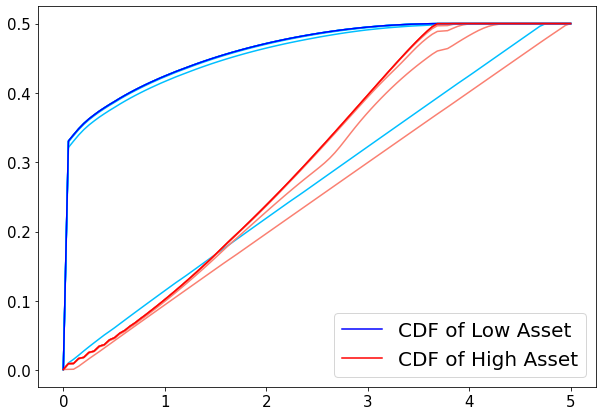

In [130]:
# Iteration Process

max_iter = 10000
tol = 1e-06
count = 0

plt.figure(figsize = (10,7))


while count < max_iter:
    
    vals = []
    for a in a_grid:
        if a < min(p_l(a_grid)):
            vals.append(π[0,0] * cdf_l0(p_l_inv(min(p_l(a_grid)))) + π[1,0] * cdf_h0(p_h_inv(min(p_h(a_grid)))))

        if min(p_l(a_grid)) <= a < min(p_h(a_grid)):
            vals.append(π[0,0] * cdf_l0(p_l_inv(a)) + π[1,0] * cdf_h0(p_h_inv(min(p_h(a_grid)))))

        if min(p_h(a_grid)) <= a <= max(p_l(a_grid)):
            vals.append(π[0,0] * cdf_l0(p_l_inv(a)) + π[1,0] * cdf_h0(p_h_inv(a)))

        if max(p_l(a_grid)) <= a <= max(p_h(a_grid)):
            vals.append(π[0,0] * cdf_l0(p_l_inv(max(p_l(a_grid)))) + π[1,0] * cdf_h0(p_h_inv(a)))

        if max(p_h(a_grid)) < a :
            vals.append(π[0,0] * cdf_l0(p_l_inv(max(p_l(a_grid)))) + π[1,0] * cdf_h0(p_h_inv(max(p_h(a_grid)))))
    
    cdf_l1 = interp1d(a_grid, vals)
    
    vals = []
    for a in a_grid:
        if a < min(p_l(a_grid)):
            vals.append(π[0,1] * cdf_l0(p_l_inv(min(p_l(a_grid)))) + π[1,1] * cdf_h0(p_h_inv(min(p_h(a_grid)))))

        if min(p_l(a_grid)) <= a < min(p_h(a_grid)):
            vals.append(π[0,1] * cdf_l0(p_l_inv(a)) + π[1,1] * cdf_h0(p_h_inv(min(p_h(a_grid)))))

        if min(p_h(a_grid)) <= a <= max(p_l(a_grid)):
            vals.append(π[0,1] * cdf_l0(p_l_inv(a)) + π[1,1] * cdf_h0(p_h_inv(a)))

        if max(p_l(a_grid)) <= a <= max(p_h(a_grid)):
            vals.append(π[0,1] * cdf_l0(p_l_inv(max(p_l(a_grid)))) + π[1,1] * cdf_h0(p_h_inv(a)))

        if max(p_h(a_grid)) < a :
            vals.append(π[0,1] * cdf_l0(p_l_inv(max(p_l(a_grid)))) + π[1,1] * cdf_h0(p_h_inv(max(p_h(a_grid)))))
    
    cdf_h1 = interp1d(a_grid, vals)
    
    err_l = np.max(np.abs(cdf_l1(a_grid) - cdf_l0(a_grid)))
    err_h = np.max(np.abs(cdf_h1(a_grid) - cdf_h0(a_grid)))
    err = np.max(np.array([err_l, err_h]))
    
    if err < tol:

        plt.plot(a_grid,cdf_l1(a_grid),label = 'CDF of Low Asset' , color = 'blue')
        plt.plot(a_grid,cdf_h1(a_grid),label = 'CDF of High Asset', color = 'red')       
        
        print('The Final Number of Iteration is', count)
        print('with error', err)
        break
        
        
    if int(count) % 50 == 0 :
        
        
        plt.plot(a_grid,cdf_l1(a_grid), color = 'deepskyblue')
        plt.plot(a_grid,cdf_h1(a_grid), color = 'salmon')
        
        print('The Iteration Number is', count)
        print('with error', err)
    
    count += 1
    cdf_l0 = cdf_l1
    cdf_h0 = cdf_h1
    
plt.legend(fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [136]:
# Expected Value

cdf_total = interp1d(a_grid, cdf_l1(a_grid) + cdf_h1(a_grid))
invcdf = interp1d(a_grid,1-cdf_total(a_grid))
invcdf_l = interp1d(a_grid,0.5-cdf_l1(a_grid))
invcdf_h = interp1d(a_grid,0.5-cdf_h1(a_grid))
m = quad(invcdf,0,5)[0]
m_l = quad(invcdf_l,0,5)[0]*2
m_h = quad(invcdf_h,0,5)[0]*2
print('total mean  = ',np.round(m,decimals=4),
      '\nmean of low income = ',np.round(m_l,decimals=4),
      '\nmean of high income = ',np.round(m_h,decimals=4))

total mean  =  1.1917 
mean of low income =  0.3828 
mean of high income =  2.0006


/var/folders/6r/0n3782p533ngcdj_ghsbn7c40000gn/T/ipykernel_60764/608410511.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  m = quad(invcdf,0,5)[0]
/var/folders/6r/0n3782p533ngcdj_ghsbn7c40000gn/T/ipykernel_60764/608410511.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval 

In [78]:
cdff = interp1d(a_grid,cdf_total(a_grid) * (1-cdf_total(a_grid)))
gini1 = quad(cdff,0,5)[0]/m
gini1

/var/folders/6r/0n3782p533ngcdj_ghsbn7c40000gn/T/ipykernel_60764/4132185950.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  gini1 = quad(cdff,0,5)[0]/m


0.5563699752304692

In [80]:
cdff_l = interp1d(a_grid, 2*cdf_l1(a_grid) * ( 1 - (2 * cdf_l1(a_grid))))
gini_l = quad(cdff_l,0,5)[0] / m_l
gini_l

/var/folders/6r/0n3782p533ngcdj_ghsbn7c40000gn/T/ipykernel_60764/4225758884.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  gini2 = quad(cdff_l,0,5)[0] / m_l


0.7624186910428805

In [81]:
cdff_h = interp1d(a_grid, 2*cdf_h1(a_grid) * ( 1 - (2 * cdf_h1(a_grid))))
gini_h = quad(cdff_h,0,5)[0] / m_h
gini_h

/var/folders/6r/0n3782p533ngcdj_ghsbn7c40000gn/T/ipykernel_60764/2860333437.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  gini_h = quad(cdff_h,0,5)[0] / m_h


0.29733989726971316